In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import scipy.stats as st
import covid
import ecom

In [2]:
# Read the US Data
us_merged_df = pd.read_csv("data/dtype_merge.csv")

In [3]:
us_merged_df.head()

,per_idx,cat_idx,dt_idx,et_idx,geo_idx,is_adj,val,cat_code,cat_desc,cat_indent,per_name,dt_code,dt_desc,dt_unit,month,year,mon/yy
0,1,5,1,0,1,0,130683.0,44000,44000: Retail Trade,0,Jan-92,SM,Sales - Monthly,MLN$,Jan,92,Jan/92
1,1,5,1,0,1,1,146925.0,44000,44000: Retail Trade,0,Jan-92,SM,Sales - Monthly,MLN$,Jan,92,Jan/92
2,1,5,2,0,1,0,235509.0,44000,44000: Retail Trade,0,Jan-92,IM,Inventories - Monthly,MLN$,Jan,92,Jan/92
3,1,5,2,0,1,1,242006.0,44000,44000: Retail Trade,0,Jan-92,IM,Inventories - Monthly,MLN$,Jan,92,Jan/92
4,1,5,3,0,1,0,1.8,44000,44000: Retail Trade,0,Jan-92,IR,Inventories/Sales Ratio,RATIO,Jan,92,Jan/92


In [4]:
# Get non-adjusted monthly overall retail sales data from the merged data
us_retail_df = us_merged_df.loc[(us_merged_df.loc[:, "is_adj"] == 0) &
                                (us_merged_df.loc[:, "cat_code"] == "44000") &
                                (us_merged_df.loc[:, "dt_code"] == "SM")]

us_retail_df = us_retail_df.drop(columns = ["per_idx", "cat_idx", "dt_idx", "et_idx", "geo_idx", "is_adj", "cat_code",
                                            "cat_desc", "cat_indent", "per_name", "dt_code", "dt_desc"])
us_retail_df.head()

,val,dt_unit,month,year,mon/yy
0,130683.0,MLN$,Jan,92,Jan/92
6,131244.0,MLN$,Feb,92,Feb/92
17,142488.0,MLN$,Mar,92,Mar/92
30,147175.0,MLN$,Apr,92,Apr/92
36,152420.0,MLN$,May,92,May/92


In [5]:
# Get non-adjusted monthly e-commerce sales data from the merged data
us_ecommerce_df = us_merged_df.loc[(us_merged_df.loc[:, "is_adj"] == 0) &
                                   (us_merged_df.loc[:, "cat_code"] == "4541") &
                                   (us_merged_df.loc[:, "dt_code"] == "SM")]

us_ecommerce_df = us_ecommerce_df.drop(columns = ["per_idx", "cat_idx", "dt_idx", "et_idx", "geo_idx", "is_adj", "cat_code", "cat_desc",
                                                  "cat_indent", "per_name", "dt_code", "dt_desc", "dt_unit", "month", "year"])

us_ecommerce_df.head()

,val,mon/yy
136756,2692.0,Jan/92
136758,2285.0,Feb/92
136764,2484.0,Mar/92
136768,2506.0,Apr/92
136770,2483.0,May/92


In [6]:
# Merge overall retail and e-commerce data into a dataframe
us_sales_df = pd.merge(us_retail_df, us_ecommerce_df, on = "mon/yy")
us_sales_df = us_sales_df.rename(columns = {"val_x":"Retail Amount", "val_y":"E-Commerce Amount"})
us_sales_df.head()

,Retail Amount,dt_unit,month,year,mon/yy,E-Commerce Amount
0,130683.0,MLN$,Jan,92,Jan/92,2692.0
1,131244.0,MLN$,Feb,92,Feb/92,2285.0
2,142488.0,MLN$,Mar,92,Mar/92,2484.0
3,147175.0,MLN$,Apr,92,Apr/92,2506.0
4,152420.0,MLN$,May,92,May/92,2483.0


In [7]:
# Calculate E-Commerce Share(%)
us_sales_df["E-Commerce Share(%)"] = us_sales_df.iloc[:, 5] / us_sales_df.iloc[:, 0] * 100

In [8]:
# Calculate overall retail and E-Commerce MoM growth(%), Convert year type %y to %Y
for idx in us_sales_df.index:
    us_sales_df.loc[idx, "year"] = us_sales_df.loc[idx, "year"] + 1900 if us_sales_df.loc[idx, "year"] > 90 else us_sales_df.loc[idx, "year"] + 2000
    
    try:
        us_sales_df.loc[idx, "Retail Growth(%)"] = (us_sales_df.loc[idx, "Retail Amount"] - us_sales_df.loc[idx-1, "Retail Amount"]) / us_sales_df.loc[idx-1, "Retail Amount"] * 100
        us_sales_df.loc[idx, "E-Commerce Growth(%)"] = (us_sales_df.loc[idx, "E-Commerce Amount"] - us_sales_df.loc[idx-1, "E-Commerce Amount"]) / us_sales_df.loc[idx-1, "E-Commerce Amount"] * 100
    except KeyError:
        pass

us_sales_df.tail()

,Retail Amount,dt_unit,month,year,mon/yy,E-Commerce Amount,E-Commerce Share(%),Retail Growth(%),E-Commerce Growth(%)
336,421093.0,MLN$,Jan,2020,Jan/20,56350.0,13.381842,-19.989170,-33.874696
337,417777.0,MLN$,Feb,2020,Feb/20,53979.0,12.920529,-0.787475,-4.207631
338,434185.0,MLN$,Mar,2020,Mar/20,62588.0,14.415053,3.927454,15.948795
339,380223.0,MLN$,Apr,2020,Apr/20,69952.0,18.397625,-12.428343,11.765834
340,465086.0,MLN$,May,2020,May/20,75973.0,16.335258,22.319271,8.607331


In [9]:
# Annual retail and e-commerce sales data
us_sales_a_df = us_sales_df.iloc[:, [0, 3, 5]].groupby("year").sum()
us_sales_a_df["E-Commerce Share(%)"] = us_sales_a_df.iloc[:, 1] / us_sales_a_df.iloc[:, 0] * 100

for idx in us_sales_a_df.index[1:]:
    us_sales_a_df.loc[idx, "Retail Growth(%)"] = (us_sales_a_df.loc[idx, "Retail Amount"] - us_sales_a_df.loc[idx-1, "Retail Amount"]) / us_sales_a_df.loc[idx-1, "Retail Amount"] * 100
    us_sales_a_df.loc[idx, "E-Commerce Growth(%)"] = (us_sales_a_df.loc[idx, "E-Commerce Amount"] - us_sales_a_df.loc[idx-1, "E-Commerce Amount"]) / us_sales_a_df.loc[idx-1, "E-Commerce Amount"] * 100

this_year, last_year = (us_sales_a_df.tail(2).index[1], us_sales_a_df.tail(2).index[0])
num_this_year = len(us_sales_df.loc[us_sales_df.loc[:, "year"] == this_year].index)

last_retail = us_sales_df.loc[us_sales_df.iloc[:, 3] == last_year].iloc[:num_this_year, 0].sum()
last_online = us_sales_df.loc[us_sales_df.iloc[:, 3] == last_year].iloc[:num_this_year, 5].sum()

us_sales_a_df.loc[this_year, "Retail Growth(%)"] = (us_sales_a_df.tail(1).iloc[0, 0] - last_retail) / last_retail * 100
us_sales_a_df.loc[this_year, "E-Commerce Growth(%)"] = (us_sales_a_df.tail(1).iloc[0, 1] - last_online) / last_online * 100

us_sales_a_df.tail()

,Retail Amount,E-Commerce Amount,E-Commerce Share(%),Retail Growth(%),E-Commerce Growth(%)
year,,,,,
2016,4852958.0,488840.0,10.073032,2.686525,12.639319
2017,5053151.0,551298.0,10.909985,4.125175,12.776778
2018,5269468.0,611743.0,11.609198,4.280834,10.964125
2019,5452206.0,705534.0,12.940340,3.467864,15.331765
2020,2118364.0,318842.0,15.051332,-2.068731,19.925376


In [10]:
# Remove data in 1992 - 2009
us_sales_a_df = us_sales_a_df.reset_index()
us_sales_df = us_sales_df.loc[us_sales_df.loc[:, "year"] >= 2010]
us_sales_a_df = us_sales_a_df.loc[us_sales_a_df.loc[:, "year"] >= 2010]
us_sales_a_df.head()

,year,Retail Amount,E-Commerce Amount,E-Commerce Share(%),Retail Growth(%),E-Commerce Growth(%)
18,2010,3818048.0,263488.0,6.901118,5.690758,11.825146
19,2011,4102952.0,294697.0,7.182560,7.462033,11.844562
20,2012,4302229.0,328655.0,7.639180,4.856918,11.523022
21,2013,4458450.0,350487.0,7.861185,3.631164,6.642832
22,2014,4639440.0,386065.0,8.321371,4.059483,10.151018


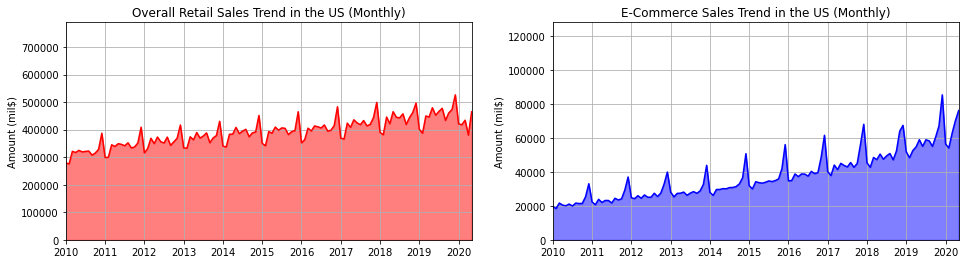

In [11]:
# Plot retail and e-commerce sales line charts for 10 years
x_axis = us_sales_df.loc[:, "mon/yy"]
x_label = list(us_sales_df.loc[:, "year"].unique())
x_label.insert(0, 2010)

y_axis_r = us_sales_df.loc[:, "Retail Amount"]
y_axis_e = us_sales_df.loc[:, "E-Commerce Amount"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(x_axis, y_axis_r, color = "r")
ax1.set_title("Overall Retail Sales Trend in the US (Monthly)")
ax1.set_ylabel("Amount (mil$)")
ax1.set_xlim(x_axis.head(1), x_axis.tail(1))
ax1.set_ylim(0, y_axis_r.max()*1.5)
ax1.grid()
ax1.fill_between(x_axis, y_axis_r, color = "r", alpha = 0.5)
ax1.set_xticks(x_axis)

ax1.xaxis.set_major_locator(MultipleLocator(12))
ax1.set_xticklabels(x_label, minor = False)

ax2.plot(x_axis, y_axis_e, color = "b")
ax2.set_title("E-Commerce Sales Trend in the US (Monthly)")
ax2.set_ylabel("Amount (mil$)")
ax2.set_xlim(x_axis.head(1), x_axis.tail(1))
ax2.set_ylim(0, y_axis_e.max()*1.5)
ax2.grid()
ax2.fill_between(x_axis, y_axis_e, color = "b", alpha = 0.5)
ax2.xaxis.set_major_locator(MultipleLocator(12))
ax2.set_xticklabels(x_label, minor = False)

plt.savefig("charts/us_sales.png", dpi = 200)

plt.show()

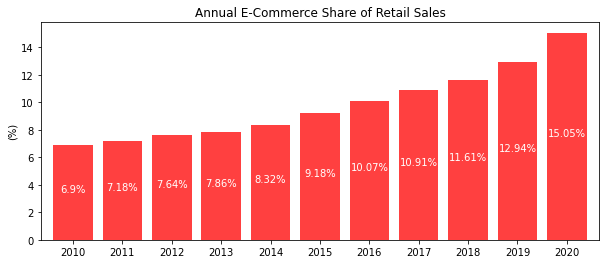

In [12]:
ax = us_sales_a_df.iloc[:, 3].plot(kind = "bar", width = 0.8, figsize=(10,4), color = "r", alpha = 0.75)
x_label = us_sales_a_df.iloc[:, 0]

for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(round(height, 2))+"%", (left+width/2, height/2), ha='center', color = "white")

plt.title("Annual E-Commerce Share of Retail Sales")
plt.ylabel("(%)")
ax.set_xticklabels(x_label, rotation = 0)
plt.savefig("charts/e-commerce_share.png", dpi = 200)
plt.show()

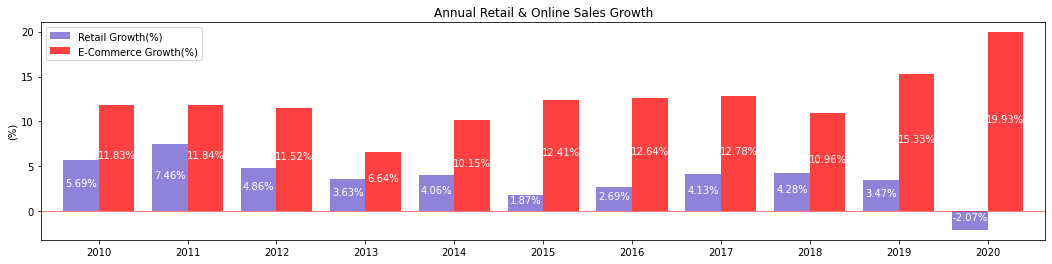

In [13]:
# Plot retail and e-commerce sales growth rate for 10 years
ax = us_sales_a_df.iloc[:, [4, 5]].plot(kind = "bar", width = 0.8, figsize=(18,4), color = ["slateblue", "r"], alpha = 0.75)

for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(round(height, 2))+"%", (left+width/2, height/2), ha='center', color = "white")

plt.title("Annual Retail & E-Comme Sales Growth")
plt.axhline(y=0, color='red', linewidth=0.5)
plt.ylabel("(%)")
ax.set_xticklabels(x_label, rotation = 0)
plt.savefig("charts/sales_growth.png", dpi = 200)
plt.show()

In [14]:
us_sales_1 = us_sales_df.tail(24)
us_sales_1

,Retail Amount,dt_unit,month,year,mon/yy,E-Commerce Amount,E-Commerce Share(%),Retail Growth(%),E-Commerce Growth(%)
317,444720.0,MLN$,Jun,2018,Jun/18,47380.0,10.653895,-4.407134,-6.005118
318,442975.0,MLN$,Jul,2018,Jul/18,49349.0,11.140358,-0.392382,4.155762
319,457386.0,MLN$,Aug,2018,Aug/18,50735.0,11.092381,3.253231,2.808568
320,418629.0,MLN$,Sep,2018,Sep/18,47028.0,11.233813,-8.473587,-7.306593
321,443581.0,MLN$,Oct,2018,Oct/18,52236.0,11.775978,5.960409,11.074254
322,461965.0,MLN$,Nov,2018,Nov/18,63881.0,13.828104,4.144452,22.293055
323,496469.0,MLN$,Dec,2018,Dec/18,67283.0,13.552306,7.468964,5.325527
324,401341.0,MLN$,Jan,2019,Jan/19,51647.0,12.868608,-19.160914,-23.239154
325,386840.0,MLN$,Feb,2019,Feb/19,48295.0,12.484490,-3.613137,-6.490212
326,449507.0,MLN$,Mar,2019,Mar/19,52458.0,11.670119,16.199721,8.619940


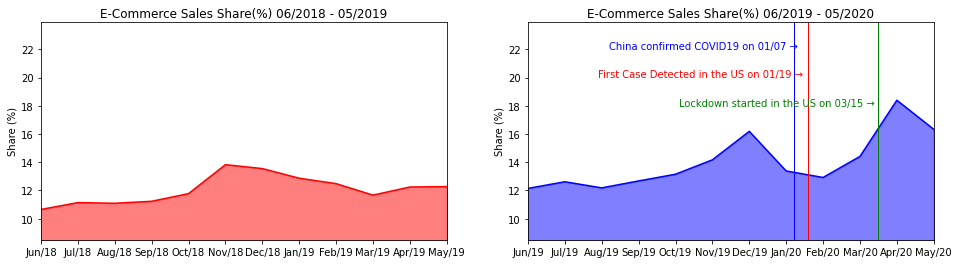

In [15]:
# Plot e-commerce share
x_axis_1 = us_sales_1.head(12).loc[:, "mon/yy"]
x_axis_2 = us_sales_1.tail(12).loc[:, "mon/yy"]

y_axis_1 = us_sales_1.head(12).iloc[:, 6]
y_axis_2 = us_sales_1.tail(12).iloc[:, 6]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(x_axis_1, y_axis_1, color = "r")
ax1.set_title("E-Commerce Sales Share(%) 06/2018 - 05/2019")
ax1.set_ylabel("Share (%)")
ax1.set_xlim(x_axis_1.head(1), x_axis_1.tail(1))
ax1.set_ylim(y_axis_2.min()*0.7, y_axis_2.max()*1.3)
ax1.fill_between(x_axis_1, y_axis_1, color = "r", alpha = 0.5)
ax1.set_xticks(x_axis_1)

ax2.plot(x_axis_2, y_axis_2, color = "b")
ax2.set_title("E-Commerce Sales Share(%) 06/2019 - 05/2020")
ax2.set_ylabel("Share (%)")
ax2.set_xlim(x_axis_2.head(1), x_axis_2.tail(1))
ax2.set_ylim(y_axis_2.min()*0.7, y_axis_2.max()*1.3)
ax2.fill_between(x_axis_2, y_axis_2, color = "b", alpha = 0.5)
ax2.axvline(x=7.22, color='blue', linewidth=1)
ax2.annotate("China confirmed COVID19 on 01/07 →", (2.2, 22), color = "blue")
ax2.axvline(x=7.6, color='red', linewidth=1)
ax2.annotate("First Case Detected in the US on 01/19 →", (1.9, 20), color = "red")
ax2.axvline(x=9.5, color='green', linewidth=1)
ax2.annotate("Lockdown started in the US on 03/15 →", (4.1, 18), color = "green")

plt.savefig("charts/e-commerce_growth.png", dpi = 200)

plt.show()

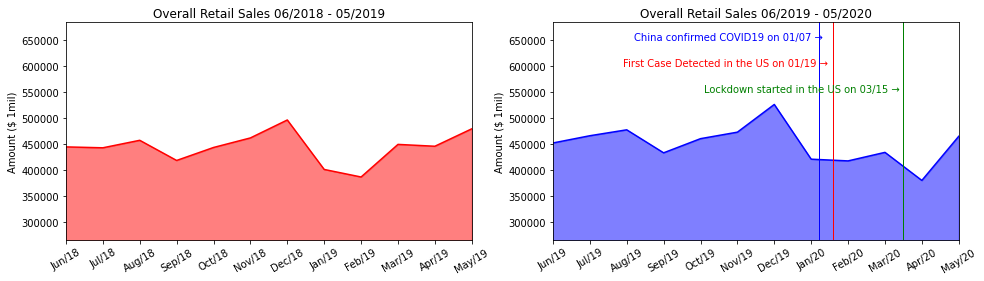

In [16]:
# Plot overall retail amount
y_axis_1 = us_sales_1.head(12).iloc[:, 0]
y_axis_2 = us_sales_1.tail(12).iloc[:, 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(x_axis_1, y_axis_1, color = "r")
ax1.set_title("Overall Retail Sales 06/2018 - 05/2019")
ax1.set_ylabel("Amount ($ 1mil)")
ax1.set_xlim(x_axis_1.head(1), x_axis_1.tail(1))
ax1.set_ylim(y_axis_2.min()*0.7, y_axis_2.max()*1.3)
ax1.fill_between(x_axis_1, y_axis_1, color = "r", alpha = 0.5)
ax1.set_xticklabels(x_axis_1, rotation = 30)

ax2.plot(x_axis_2, y_axis_2, color = "b")
ax2.set_title("Overall Retail Sales 06/2019 - 05/2020")
ax2.set_ylabel("Amount ($ 1mil)")
ax2.set_xlim(x_axis_2.head(1), x_axis_2.tail(1))
ax2.set_ylim(y_axis_2.min()*0.7, y_axis_2.max()*1.3)
ax2.fill_between(x_axis_2, y_axis_2, color = "b", alpha = 0.5)
ax2.set_xticklabels(x_axis_2, rotation = 30)
ax2.axvline(x=7.22, color='blue', linewidth=1)
ax2.annotate("China confirmed COVID19 on 01/07 →", (2.2, 650000), color = "blue")
ax2.axvline(x=7.6, color='red', linewidth=1)
ax2.annotate("First Case Detected in the US on 01/19 →", (1.9, 600000), color = "red")
ax2.axvline(x=9.5, color='green', linewidth=1)
ax2.annotate("Lockdown started in the US on 03/15 →", (4.1, 550000), color = "green")

plt.savefig("charts/e-commerce_growth.png", dpi = 200)

plt.show()

In [17]:
covid_df = covid.get_num_of_cases(["united-states", "canada", "china", "south-korea"])
covid_df

,Country,Date,New Cases,Cumulative Cases
0,United States of America,Jan/2020,7,7
1,United States of America,Feb/2020,17,24
2,United States of America,Mar/2020,188700,188724
3,United States of America,Apr/2020,883943,1.07267e+06
4,United States of America,May/2020,726457,1.79912e+06
5,Canada,Jan/2020,4,4
6,Canada,Feb/2020,16,20
7,Canada,Mar/2020,8507,8527
8,Canada,Apr/2020,45930,54457
9,Canada,May/2020,38021,92478


In [18]:
canada_df = ecom.get_canada_df_m()
canada_a_df = ecom.get_canada_df_y()
korea_df = ecom.get_korea_df_m()
korea_a_df = ecom.get_korea_df_y()
canada_2 = canada_df.tail(24)
korea_2 = korea_df.tail(24)
canada_df.head()

,Date,Overall Retail,E-Commerce,E-Shopping and Mail-Order Houses,Retail Growth(%),E-Commerce Growth(%),E-Shopping Growth(%),E-Commerce Share(%),E-Shopping Share(%)
0,Jan/2016,27921.8,654.742,507.173,NaN,NaN,NaN,2.34492,1.81641
1,Feb/2016,27474.6,589.219,460.148,-1.6014,-10.0075,-9.27206,2.14459,1.67481
2,Mar/2016,31913.2,646.028,508.351,16.1554,9.6414,10.4757,2.02432,1.59292
3,Apr/2016,34444.7,684.112,512.51,7.93246,5.89515,0.818126,1.98611,1.48792
4,May/2016,36405.5,683.764,508.352,5.69257,-0.050834,-0.811341,1.87819,1.39636


In [19]:
korea_df.head()

,Date,Overall Retail,E-Commerce,Retail Growth(%),E-Commerce Growth(%),E-Commerce Share(%)
0,Jan/2017,29876.886667,6092.065833,NaN,NaN,20.390564
1,Feb/2017,27563.032500,5957.374167,-7.744629,-2.210936,21.613638
2,Mar/2017,30489.673333,6455.842500,10.617993,8.367249,21.173866
3,Apr/2017,29905.277500,6150.662500,-1.916701,-4.727191,20.567147
4,May/2017,31025.580833,6351.432500,3.746173,3.264201,20.471599


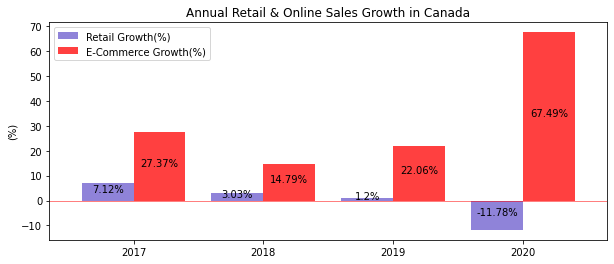

In [20]:
# Plot retail and e-commerce sales growth rate for 4 years
ax = canada_a_df.iloc[1:, [4, 5]].plot(kind = "bar", width = 0.8, figsize=(10,4), color = ["slateblue", "r"], alpha = 0.75)
x_label = canada_a_df.iloc[1:, 0]

for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(round(height, 2))+"%", (left+width/2, height/2), ha='center', color = "black")

plt.title("Annual Retail & Online Sales Growth in Canada")
plt.axhline(y=0, color='red', linewidth=0.5)
plt.ylabel("(%)")
ax.set_xticklabels(x_label, rotation = 0)
plt.savefig("charts/sales_growth_canada.png", dpi = 200)
plt.show()

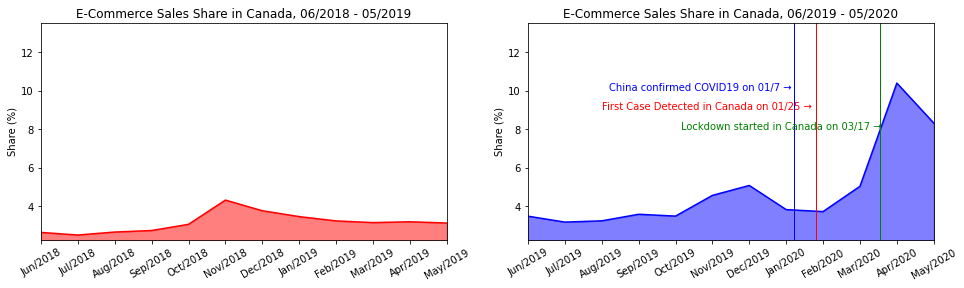

In [21]:
# Plot e-commerce share in Canada
y_axis_1 = canada_2.head(12).iloc[:, 7].astype(float)
y_axis_2 = canada_2.tail(12).iloc[:, 7].astype(float)

x_axis_1 = canada_2.head(12).loc[:, "Date"]
x_axis_2 = canada_2.tail(12).loc[:, "Date"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(x_axis_1, y_axis_1, color = "r")
ax1.set_title("E-Commerce Sales Share in Canada, 06/2018 - 05/2019")
ax1.set_ylabel("Share (%)")
ax1.set_xlim(x_axis_1.head(1), x_axis_1.tail(1))
ax1.set_ylim(y_axis_2.min()*0.7, y_axis_2.max()*1.3)
ax1.fill_between(x_axis_1, y_axis_1, color = "r", alpha = 0.5)
ax1.set_xticklabels(x_axis_1, rotation = 30)

ax2.plot(x_axis_2, y_axis_2, color = "b")
ax2.set_title("E-Commerce Sales Share in Canada, 06/2019 - 05/2020")
ax2.set_ylabel("Share (%)")
ax2.set_xlim(x_axis_2.head(1), x_axis_2.tail(1))
ax2.set_ylim(y_axis_2.min()*0.7, y_axis_2.max()*1.3)
ax2.fill_between(x_axis_2, y_axis_2, color = "b", alpha = 0.5)
ax2.set_xticklabels(x_axis_2, rotation = 30)
ax2.axvline(x=7.22, color='blue', linewidth=1)
ax2.annotate("China confirmed COVID19 on 01/7 →", (2.2, 10), color = "blue")
ax2.axvline(x=7.8, color='red', linewidth=1)
ax2.annotate("First Case Detected in Canada on 01/25 →", (2, 9), color = "red")
ax2.axvline(x=9.54, color='green', linewidth=1)
ax2.annotate("Lockdown started in Canada on 03/17 →", (4.14, 8), color = "green")

plt.savefig("charts/e-commerce_share_canada.png", dpi = 200)

plt.show()

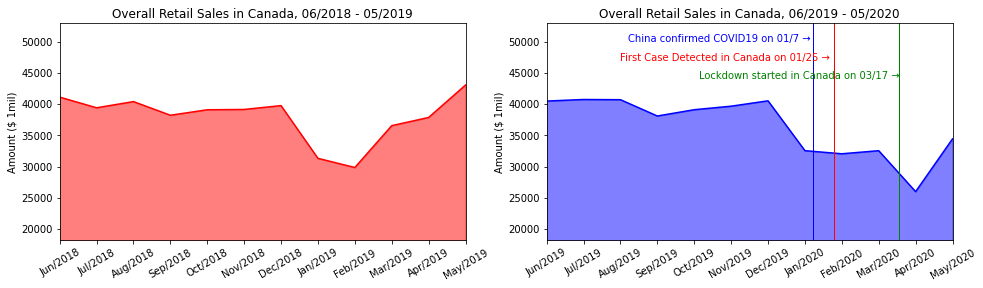

In [22]:
# Plot overall retail amount
y_axis_1 = canada_2.head(12).iloc[:, 1].astype(float)
y_axis_2 = canada_2.tail(12).iloc[:, 1].astype(float)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(x_axis_1, y_axis_1, color = "r")
ax1.set_title("Overall Retail Sales in Canada, 06/2018 - 05/2019")
ax1.set_ylabel("Amount ($ 1mil)")
ax1.set_xlim(x_axis_1.head(1), x_axis_1.tail(1))
ax1.set_ylim(y_axis_2.min()*0.7, y_axis_2.max()*1.3)
ax1.fill_between(x_axis_1, y_axis_1, color = "r", alpha = 0.5)
ax1.set_xticklabels(x_axis_1, rotation = 30)

ax2.plot(x_axis_2, y_axis_2, color = "b")
ax2.set_title("Overall Retail Sales in Canada, 06/2019 - 05/2020")
ax2.set_ylabel("Amount ($ 1mil)")
ax2.set_xlim(x_axis_2.head(1), x_axis_2.tail(1))
ax2.set_ylim(y_axis_2.min()*0.7, y_axis_2.max()*1.3)
ax2.fill_between(x_axis_2, y_axis_2, color = "b", alpha = 0.5)
ax2.set_xticklabels(x_axis_2, rotation = 30)
ax2.axvline(x=7.22, color='blue', linewidth=1)
ax2.annotate("China confirmed COVID19 on 01/7 →", (2.2, 50000), color = "blue")
ax2.axvline(x=7.8, color='red', linewidth=1)
ax2.annotate("First Case Detected in Canada on 01/25 →", (2, 47000), color = "red")
ax2.axvline(x=9.54, color='green', linewidth=1)
ax2.annotate("Lockdown started in Canada on 03/17 →", (4.14, 44000), color = "green")


plt.savefig("charts/retail_sales_canada.png", dpi = 200)

plt.show()

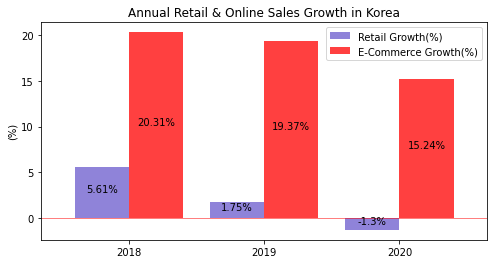

In [23]:
# Plot retail and e-commerce sales growth rate for 3 years
ax = korea_a_df.iloc[1:, [3, 4]].plot(kind = "bar", width = 0.8, figsize=(8,4), color = ["slateblue", "r"], alpha = 0.75)
x_label = korea_a_df.iloc[1:, 0]

for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(round(height, 2))+"%", (left+width/2, height/2), ha='center', color = "black")

plt.title("Annual Retail & Online Sales Growth in Korea")
plt.axhline(y=0, color='red', linewidth=0.5)
plt.ylabel("(%)")
ax.set_xticklabels(x_label, rotation = 0)
plt.savefig("charts/sales_growth_korea.png", dpi = 200)
plt.show()

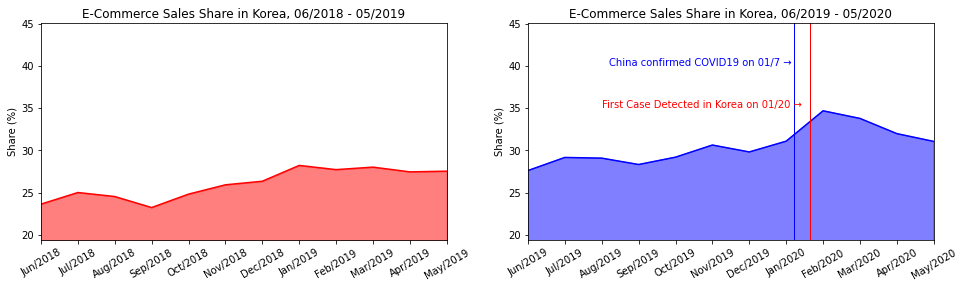

In [24]:
# Plot e-commerce share in Korea
y_axis_1 = korea_2.head(12).iloc[:, 5].astype(float)
y_axis_2 = korea_2.tail(12).iloc[:, 5].astype(float)

x_axis_1 = korea_2.head(12).loc[:, "Date"]
x_axis_2 = korea_2.tail(12).loc[:, "Date"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(x_axis_1, y_axis_1, color = "r")
ax1.set_title("E-Commerce Sales Share in Korea, 06/2018 - 05/2019")
ax1.set_ylabel("Share (%)")
ax1.set_xlim(x_axis_1.head(1), x_axis_1.tail(1))
ax1.set_ylim(y_axis_2.min()*0.7, y_axis_2.max()*1.3)
ax1.fill_between(x_axis_1, y_axis_1, color = "r", alpha = 0.5)
ax1.set_xticklabels(x_axis_1, rotation = 30)

ax2.plot(x_axis_2, y_axis_2, color = "b")
ax2.set_title("E-Commerce Sales Share in Korea, 06/2019 - 05/2020")
ax2.set_ylabel("Share (%)")
ax2.set_xlim(x_axis_2.head(1), x_axis_2.tail(1))
ax2.set_ylim(y_axis_2.min()*0.7, y_axis_2.max()*1.3)
ax2.fill_between(x_axis_2, y_axis_2, color = "b", alpha = 0.5)
ax2.set_xticklabels(x_axis_2, rotation = 30)
ax2.axvline(x=7.22, color='blue', linewidth=1)
ax2.annotate("China confirmed COVID19 on 01/7 →", (2.2, 40), color = "blue")
ax2.axvline(x=7.65, color='red', linewidth=1)
ax2.annotate("First Case Detected in Korea on 01/20 →", (2, 35), color = "red")

plt.savefig("charts/e-commerce_share_korea.png", dpi = 200)

plt.show()

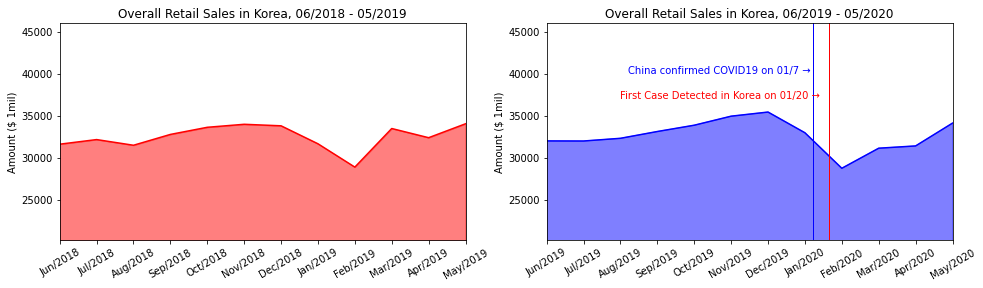

In [25]:
# Plot overall retail amount
y_axis_1 = korea_2.head(12).iloc[:, 1].astype(float)
y_axis_2 = korea_2.tail(12).iloc[:, 1].astype(float)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(x_axis_1, y_axis_1, color = "r")
ax1.set_title("Overall Retail Sales in Korea, 06/2018 - 05/2019")
ax1.set_ylabel("Amount ($ 1mil)")
ax1.set_xlim(x_axis_1.head(1), x_axis_1.tail(1))
ax1.set_ylim(y_axis_2.min()*0.7, y_axis_2.max()*1.3)
ax1.fill_between(x_axis_1, y_axis_1, color = "r", alpha = 0.5)
ax1.set_xticklabels(x_axis_1, rotation = 30)

ax2.plot(x_axis_2, y_axis_2, color = "b")
ax2.set_title("Overall Retail Sales in Korea, 06/2019 - 05/2020")
ax2.set_ylabel("Amount ($ 1mil)")
ax2.set_xlim(x_axis_2.head(1), x_axis_2.tail(1))
ax2.set_ylim(y_axis_2.min()*0.7, y_axis_2.max()*1.3)
ax2.fill_between(x_axis_2, y_axis_2, color = "b", alpha = 0.5)
ax2.set_xticklabels(x_axis_2, rotation = 30)
ax2.axvline(x=7.22, color='blue', linewidth=1)
ax2.annotate("China confirmed COVID19 on 01/7 →", (2.2, 40000), color = "blue")
ax2.axvline(x=7.65, color='red', linewidth=1)
ax2.annotate("First Case Detected in Korea on 01/20 →", (2, 37000), color = "red")

plt.savefig("charts/retail_sales_korea.png", dpi = 200)

plt.show()

In [26]:
covid_sales_df = covid_df.loc[(covid_df.loc[:, "Country"] == "United States of America") |
                              (covid_df.loc[:, "Country"] == "Canada") |
                              (covid_df.loc[:, "Country"] == "Korea (South)")]
covid_sales_df

,Country,Date,New Cases,Cumulative Cases
0,United States of America,Jan/2020,7,7
1,United States of America,Feb/2020,17,24
2,United States of America,Mar/2020,188700,188724
3,United States of America,Apr/2020,883943,1.07267e+06
4,United States of America,May/2020,726457,1.79912e+06
5,Canada,Jan/2020,4,4
6,Canada,Feb/2020,16,20
7,Canada,Mar/2020,8507,8527
8,Canada,Apr/2020,45930,54457
9,Canada,May/2020,38021,92478


In [75]:
covid_sales_us = covid_sales_df.iloc[:5, :]
covid_sales_ca = covid_sales_df.iloc[5:10, :]
covid_sales_kr = covid_sales_df.iloc[10:15, :]

covid_merge_df = pd.merge(covid_sales_us, covid_sales_ca, on = "Date")
covid_merge_df = pd.merge(covid_merge_df, covid_sales_kr, on = "Date")
covid_merge_df = covid_merge_df.rename(columns = {"New Cases_x":"US Cases", "New Cases_y":"CA Cases", "New Cases":"KR Cases",
                                                  "Cumulative Cases_x":"US Cumulative Cases", "Cumulative Cases_y":"US Cumulative Cases",
                                                  "Cumulative Cases":"KR Cumulative Cases", "E-Commerce Growth(%)_x":"US E-Commerce Growth(%)",
                                                  "E-Commerce Growth(%)_y":"CA E-Commerce Growth(%)", "E-Commerce Growth(%)":"KR E-Commerce Growth(%)",
                                                  "E-Commerce Share(%)_x":"US E-Commerce Share(%)", "E-Commerce Share(%)_y":"CA E-Commerce Share(%)",
                                                  "E-Commerce Share(%)":"KR E-Commerce Share(%)", "New Cases per 100000_x":"US New Cases per 100k",
                                                  "New Cases per 100000_y":"CA New Cases per 100k", "New Cases per 100000":"KR New Cases per 100k"})
                                        
covid_merge_df

,Country_x,Date,US Cases,US Cumulative Cases,US E-Commerce Growth(%),US E-Commerce Share(%),US New Cases per 100k,Cumulative Cases per 100000_x,Country_y,CA Cases,...,CA E-Commerce Share(%),CA New Cases per 100k,Cumulative Cases per 100000_y,Country,KR Cases,KR Cumulative Cases,KR E-Commerce Growth(%),KR E-Commerce Share(%),KR New Cases per 100k,Cumulative Cases per 100000
0,United States of America,Jan/2020,7,7,-33.8747,13.3818,0.002133,0.002133,Canada,4,...,3.83043,0.010641,0.010641,Korea (South),11,11,-2.99488,31.0855,0.021455,0.021455
1,United States of America,Feb/2020,17,24,-4.20763,12.9205,0.005180,0.007313,Canada,16,...,3.72754,0.042565,0.053206,Korea (South),3139,3150,-2.77543,34.6837,6.122586,6.144041
2,United States of America,Mar/2020,188700,188724,15.9488,14.4151,57.495430,57.502742,Canada,8507,...,5.04212,22.631019,22.684225,Korea (South),6636,9786,5.52923,33.7828,12.943447,19.087489
3,United States of America,Apr/2020,883943,1.07267e+06,11.7658,18.3976,269.330591,326.833333,Canada,45930,...,10.4069,122.186752,144.870976,Korea (South),988,10774,-4.51095,31.9807,1.927083,21.014572
4,United States of America,May/2020,726457,1.79912e+06,8.60733,16.3353,221.345826,548.179159,Canada,38021,...,8.33053,101.146582,246.017558,Korea (South),729,11503,5.53152,31.0556,1.421907,22.436479


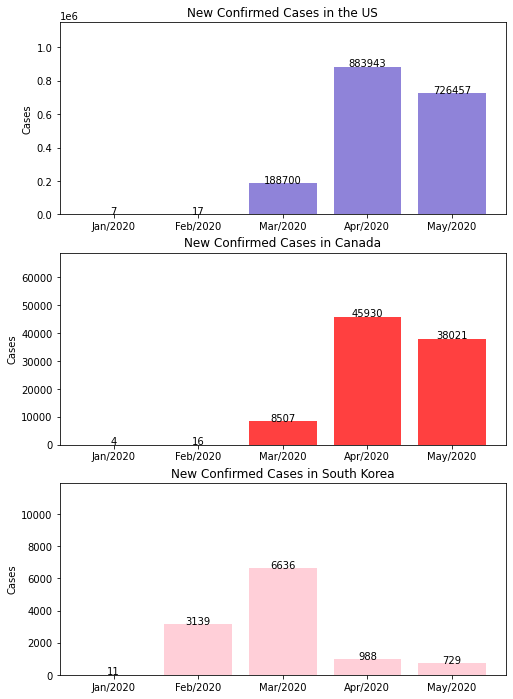

In [78]:
x_label = list(covid_merge_df.iloc[:, 1])

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 12))
trace1 = ax1.bar(range(len(x_label)), covid_merge_df.iloc[:, 2], width = 0.8, color = "slateblue", alpha = 0.75)
trace2 = ax2.bar(range(len(x_label)), covid_merge_df.iloc[:, 9], width = 0.8, color = "r", alpha = 0.75)
trace3 = ax3.bar(range(len(x_label)), covid_merge_df.iloc[:, 16], width = 0.8, color = "pink", alpha = 0.75)

for p in ax1.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax1.annotate(int(height), (left+width/2, height), ha='center', color = "black")

for p in ax2.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax2.annotate(int(height), (left+width/2, height), ha='center', color = "black")

for p in ax3.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax3.annotate(int(height), (left+width/2, height), ha='center', color = "black")

ax1.set_title("New Confirmed Cases in the US")
ax2.set_title("New Confirmed Cases in Canada")
ax3.set_title("New Confirmed Cases in South Korea")

ax1.set_ylabel("Cases")
ax2.set_ylabel("Cases")
ax3.set_ylabel("Cases")

ax1.set_ylim(0, covid_merge_df.iloc[:, 2].max()*1.3)
ax2.set_ylim(0, covid_merge_df.iloc[:, 9].max()*1.5)
ax3.set_ylim(0, covid_merge_df.iloc[:, 16].max()*1.8)

ax1.set_xticks(range(len(x_label)))
ax2.set_xticks(range(len(x_label)))
ax3.set_xticks(range(len(x_label)))

ax1.set_xticklabels(x_label, rotation = 0)
ax2.set_xticklabels(x_label, rotation = 0)
ax3.set_xticklabels(x_label, rotation = 0)

plt.savefig("charts/confirmed_cases.png", dpi = 200)
plt.show()

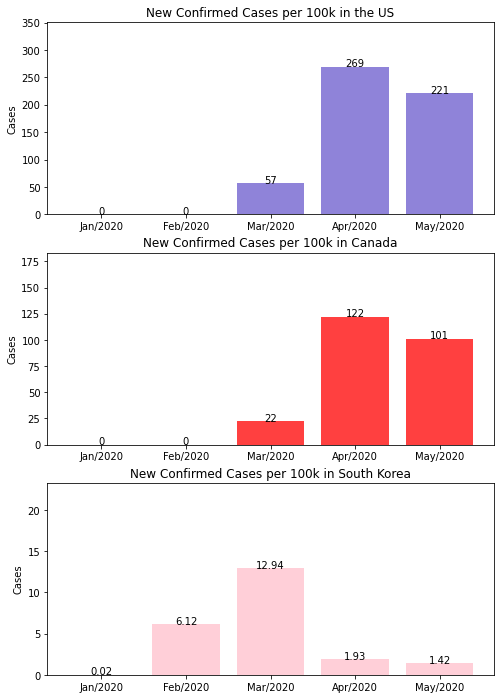

In [80]:
x_label = list(covid_merge_df.iloc[:, 1])

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 12))
trace1 = ax1.bar(range(len(x_label)), covid_merge_df.iloc[:, 6], width = 0.8, color = "slateblue", alpha = 0.75)
trace2 = ax2.bar(range(len(x_label)), covid_merge_df.iloc[:, 13], width = 0.8, color = "r", alpha = 0.75)
trace3 = ax3.bar(range(len(x_label)), covid_merge_df.iloc[:, 20], width = 0.8, color = "pink", alpha = 0.75)

for p in ax1.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax1.annotate(int(height), (left+width/2, height), ha='center', color = "black")

for p in ax2.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax2.annotate(int(height), (left+width/2, height), ha='center', color = "black")

for p in ax3.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax3.annotate(round(height, 2), (left+width/2, height), ha='center', color = "black")

ax1.set_title("New Confirmed Cases per 100k in the US")
ax2.set_title("New Confirmed Cases per 100k in Canada")
ax3.set_title("New Confirmed Cases per 100k in South Korea")

ax1.set_ylabel("Cases")
ax2.set_ylabel("Cases")
ax3.set_ylabel("Cases")

ax1.set_ylim(0, covid_merge_df.iloc[:, 6].max()*1.3)
ax2.set_ylim(0, covid_merge_df.iloc[:, 13].max()*1.5)
ax3.set_ylim(0, covid_merge_df.iloc[:, 20].max()*1.8)

ax1.set_xticks(range(len(x_label)))
ax2.set_xticks(range(len(x_label)))
ax3.set_xticks(range(len(x_label)))

ax1.set_xticklabels(x_label, rotation = 0)
ax2.set_xticklabels(x_label, rotation = 0)
ax3.set_xticklabels(x_label, rotation = 0)

plt.savefig("charts/confirmed_cases_100k.png", dpi = 200)
plt.show()

In [28]:
us_idx = covid_sales_df.loc[covid_sales_df.loc[:, "Country"] == "United States of America"].index
ca_idx = covid_sales_df.loc[covid_sales_df.loc[:, "Country"] == "Canada"].index
kr_idx = covid_sales_df.loc[covid_sales_df.loc[:, "Country"] == "Korea (South)"].index
covid_sales_df = covid_sales_df.reset_index(drop = True)

sr_1 = pd.Series()
sr_1 = sr_1.append(us_sales_1.tail(5).loc[: ,"E-Commerce Growth(%)"], ignore_index = True)
sr_1 = sr_1.append(canada_2.tail(5).loc[:, "E-Commerce Growth(%)"], ignore_index = True)
sr_1 = sr_1.append(korea_2.tail(5).loc[:, "E-Commerce Growth(%)"], ignore_index = True)

sr_2 = pd.Series()
sr_2 = sr_2.append(us_sales_1.tail(5).loc[: ,"E-Commerce Share(%)"], ignore_index = True)
sr_2 = sr_2.append(canada_2.tail(5).loc[:, "E-Commerce Share(%)"], ignore_index = True)
sr_2 = sr_2.append(korea_2.tail(5).loc[:, "E-Commerce Share(%)"], ignore_index = True)

covid_sales_df.loc[:, "E-Commerce Growth(%)"] =  sr_1
covid_sales_df.loc[:, "E-Commerce Share(%)"] =  sr_2
covid_sales_df

C:\Users\Sean\anaconda3\envs\bootcamp\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
C:\Users\Sean\anaconda3\envs\bootcamp\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # This is added back by InteractiveShellApp.init_path()


,Country,Date,New Cases,Cumulative Cases,E-Commerce Growth(%),E-Commerce Share(%)
0,United States of America,Jan/2020,7,7,-33.8747,13.3818
1,United States of America,Feb/2020,17,24,-4.20763,12.9205
2,United States of America,Mar/2020,188700,188724,15.9488,14.4151
3,United States of America,Apr/2020,883943,1.07267e+06,11.7658,18.3976
4,United States of America,May/2020,726457,1.79912e+06,8.60733,16.3353
5,Canada,Jan/2020,4,4,-39.4785,3.83043
6,Canada,Feb/2020,16,20,-4.16841,3.72754
7,Canada,Mar/2020,8507,8527,37.3407,5.04212
8,Canada,Apr/2020,45930,54457,64.9133,10.4069
9,Canada,May/2020,38021,92478,5.99406,8.33053


In [29]:
x_axis = covid_sales_df.iloc[:, 2].astype(float)
y_axis = covid_sales_df.iloc[:, 4].astype(float)

print(f"The correlation coefficien between New Cases and E-Commerce Growth(%) is {round(st.pearsonr(x_axis, y_axis)[0], 2)}")

The correlation coefficien between New Cases and E-Commerce Growth(%) is 0.15


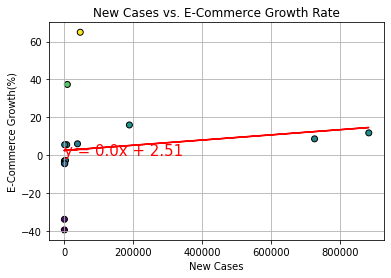

In [30]:
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))

plt.scatter(x_axis, y_axis, c = y_axis, cmap = "viridis", edgecolors = "black")
plt.plot(x_axis, regress_values, "r-")
plt.annotate(line_eq, (0.0010, 0), fontsize = 15, color = "red")
plt.title("New Cases vs. E-Commerce Growth Rate")
plt.grid()
plt.xlabel("New Cases")
plt.ylabel("E-Commerce Growth(%)")
plt.savefig("charts/new_cases_vs._growth_rate.png", dpi = 200)
plt.show()

In [31]:
us_pop = 328200000
ca_pop = 37590000
kr_pop = 51269185

for idx in covid_sales_df.index:
    if covid_sales_df.loc[idx, "Country"] == "United States of America":
        covid_sales_df.loc[idx, "New Cases per 100000"] = covid_sales_df.loc[idx, "New Cases"] / us_pop * 100000
        covid_sales_df.loc[idx, "Cumulative Cases per 100000"] = covid_sales_df.loc[idx, "Cumulative Cases"] / us_pop * 100000
    elif covid_sales_df.loc[idx, "Country"] == "Canada":
        covid_sales_df.loc[idx, "New Cases per 100000"] = covid_sales_df.loc[idx, "New Cases"] / ca_pop * 100000
        covid_sales_df.loc[idx, "Cumulative Cases per 100000"] = covid_sales_df.loc[idx, "Cumulative Cases"] / ca_pop * 100000
    else:
        covid_sales_df.loc[idx, "New Cases per 100000"] = covid_sales_df.loc[idx, "New Cases"] / kr_pop * 100000
        covid_sales_df.loc[idx, "Cumulative Cases per 100000"] = covid_sales_df.loc[idx, "Cumulative Cases"] / kr_pop * 100000

covid_sales_df

,Country,Date,New Cases,Cumulative Cases,E-Commerce Growth(%),E-Commerce Share(%),New Cases per 100000,Cumulative Cases per 100000
0,United States of America,Jan/2020,7,7,-33.8747,13.3818,0.002133,0.002133
1,United States of America,Feb/2020,17,24,-4.20763,12.9205,0.005180,0.007313
2,United States of America,Mar/2020,188700,188724,15.9488,14.4151,57.495430,57.502742
3,United States of America,Apr/2020,883943,1.07267e+06,11.7658,18.3976,269.330591,326.833333
4,United States of America,May/2020,726457,1.79912e+06,8.60733,16.3353,221.345826,548.179159
5,Canada,Jan/2020,4,4,-39.4785,3.83043,0.010641,0.010641
6,Canada,Feb/2020,16,20,-4.16841,3.72754,0.042565,0.053206
7,Canada,Mar/2020,8507,8527,37.3407,5.04212,22.631019,22.684225
8,Canada,Apr/2020,45930,54457,64.9133,10.4069,122.186752,144.870976
9,Canada,May/2020,38021,92478,5.99406,8.33053,101.146582,246.017558


In [32]:
x_axis = covid_sales_df.iloc[:, 6].astype(float)
y_axis = covid_sales_df.iloc[:, 4].astype(float)

print(f"The correlation coefficient between New Cases per 100000 and E-Commerce Growth(%) is {round(st.pearsonr(x_axis, y_axis)[0], 2)}")

The correlation coefficien between New Cases per 100000 and E-Commerce Growth(%) is 0.39


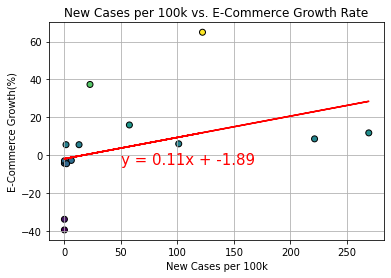

In [33]:
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))

plt.scatter(x_axis, y_axis, c = y_axis, cmap = "viridis", edgecolors = "black")
plt.plot(x_axis, regress_values, "r-")
plt.title("New Cases per 100k vs. E-Commerce Growth Rate")
plt.annotate(line_eq, (50, -5), fontsize = 15, color = "red")
plt.grid()
plt.xlabel("New Cases per 100k")
plt.ylabel("E-Commerce Growth(%)")
plt.savefig("charts/new_cases_per_100k_vs._growth_rate.png", dpi = 200)
plt.show()

In [34]:
x_axis = covid_sales_df.iloc[:, 7].astype(float)
y_axis = covid_sales_df.iloc[:, 4].astype(float)

print(f"The correlation coefficient between New Cases per 100k and E-Commerce Growth(%) is {round(st.pearsonr(x_axis, y_axis)[0], 2)}")

The correlation coefficien between New Cases per 100k and E-Commerce Growth(%) is 0.27


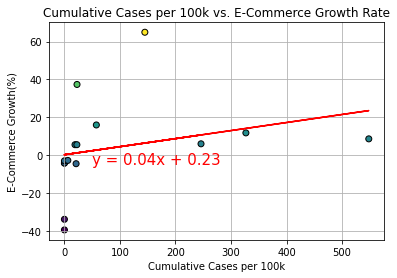

In [35]:
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))

plt.scatter(x_axis, y_axis, c = y_axis, cmap = "viridis", edgecolors = "black")
plt.plot(x_axis, regress_values, "r-")
plt.title("Cumulative Cases per 100k vs. E-Commerce Growth Rate")
plt.annotate(line_eq, (50, -5), fontsize = 15, color = "red")
plt.grid()
plt.xlabel("Cumulative Cases per 100k")
plt.ylabel("E-Commerce Growth(%)")
plt.savefig("charts/cumulative_cases_per_100k_vs._growth_rate.png", dpi = 200)
plt.show()

In [36]:
x_axis = covid_sales_df.iloc[:, 2].astype(float)
y_axis = covid_sales_df.iloc[:, 5].astype(float)

print(f"The correlation coefficient between New Cases and E-Commerce Share(%) is {round(st.pearsonr(x_axis, y_axis)[0], 2)}")

The correlation coefficien between New Cases and E-Commerce Share(%) is -0.05


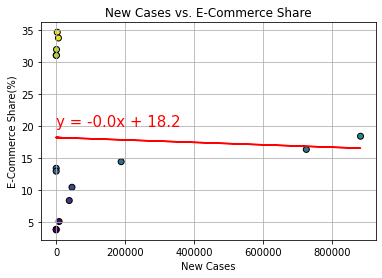

In [37]:
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))

plt.scatter(x_axis, y_axis, c = y_axis, cmap = "viridis", edgecolors = "black")
plt.plot(x_axis, regress_values, "r-")
plt.title("New Cases vs. E-Commerce Share")
plt.annotate(line_eq, (50, 20), fontsize = 15, color = "red")
plt.grid()
plt.xlabel("New Cases")
plt.ylabel("E-Commerce Share(%)")
plt.savefig("charts/new_cases_vs._share.png", dpi = 200)
plt.show()

In [38]:
x_axis = covid_sales_df.iloc[:, 6].astype(float)
y_axis = covid_sales_df.iloc[:, 5].astype(float)

print(f"The correlation coefficient between New Cases per 100k and E-Commerce Share(%) is {round(st.pearsonr(x_axis, y_axis)[0], 2)}")

The correlation coefficien between New Cases per 100k and E-Commerce Share(%) is -0.16


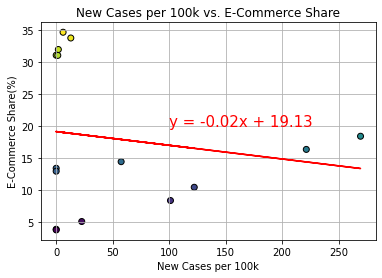

In [39]:
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))

plt.scatter(x_axis, y_axis, c = y_axis, cmap = "viridis", edgecolors = "black")
plt.plot(x_axis, regress_values, "r-")
plt.title("New Cases per 100k vs. E-Commerce Share")
plt.annotate(line_eq, (100, 20), fontsize = 15, color = "red")
plt.grid()
plt.xlabel("New Cases per 100k")
plt.ylabel("E-Commerce Share(%)")
plt.savefig("charts/new_cases_per_100k_vs._share.png", dpi = 200)
plt.show()